### Different types of recommendation system
1. Content based : You will be suggested content based on what genre you are watching
2. Collaborative Filtering : You will be suggested content based on the content which people similar to you like
3. Hybrid

- We are using Content based filtering in this project

### Project Flow
1. Obtaining Data : TMDB 5000 Training Data
2. Data Preprocessing
3. Model Training
4. UI using gradio


IMPORTING LIBRARIES


In [14]:
# !pip install sklearn
# !pip install gradio
# !pip install ntlk
# !pip install ast
# !pip install typing-extensions==4.8.0
!pip3 install typing-extensions -U

In [17]:
!pip install doc

  Preparing metadata (setup.py) ... done
  Created wheel for doc: filename=doc-0.1.0-py3-none-any.whl size=1005 sha256=355150a7d27cde5eb8377eee430feb4d5c5562a29d26732c28f3b1cca4d3f67b
  Stored in directory: /root/.cache/pip/wheels/3b/1e/86/27b026c7e0b2ffd56bc0de6d04ae732ee12c84c8e39c49ab92
Successfully built doc


In [18]:

import numpy as np
import pandas as pd
import ast
import nltk
import gradio as gr
# !pip install sklearn
# !pip install gradio
# !pip install ntlk
# !pip install ast
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem.porter import PorterStemmer

ImportError: ignored

## Mounting Google drive and giving path
- Comment out this part if using in jupyter notebook

In [ ]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

In [ ]:
cd drive/MyDrive/

# Data Processing


In [ ]:
movies = pd.read_csv('tmdb_5000_movies.csv') # budget , genre , homepage , description etc.
# Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
#        'original_title', 'overview', 'popularity', 'production_companies',
#        'production_countries', 'release_date', 'revenue', 'runtime',
#        'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
#        'vote_count'],
#       dtype='object')
credits = pd.read_csv('tmdb_5000_credits.csv') # ( cast , crew )
# Index(['movie_id', 'title', 'cast', 'crew'], dtype='object')

# movies.columns
# credits.columns

In [ ]:
# Merging the credits dataframe into the movies dataframe based on the
# column : 'title'

print("shape before merging :" , movies.shape)
movies = movies.merge(credits , on= 'title')
print("shape after merging :" , movies.shape)

# Our datset majorly contains English movies so original language would be a good input variable

In [ ]:
movies.info()

### Identifying useful columns to be used as input variable


In [ ]:


# #   Column                Non-Null Count  Dtype    IMP
# ---  ------                --------------  -----
# 0.   budget                4803 non-null   int64    n
# 1.   genres                4803 non-null   object   y
# 2.   homepage              1712 non-null   object   n
# 3.   id                    4803 non-null   int64    y
# 4.   keywords              4803 non-null   object   y
# 5.   original_language     4803 non-null   object   n
# 6.   original_title        4803 non-null   object   n
# 7.   overview              4800 non-null   object   y
# 8.   popularity            4803 non-null   float64  n
# 9.   production_companies  4803 non-null   object   n
# 10.  production_countries  4803 non-null   object   n
# 11.  release_date          4802 non-null   object   y
# 12.  revenue               4803 non-null   int64    n
# 13.  runtime               4801 non-null   float64  n
# 14.  spoken_languages      4803 non-null   object   n
# 15.  status                4803 non-null   object   n
# 16.  tagline               3959 non-null   object   n
# 17.  title                 4803 non-null   object   y
# 18.  vote_average          4803 non-null   float64  n
# 19.  vote_count            4809 non-null   int64    n
# 20.  movie_id              4809 non-null   int64    n
# 21.  cast                  4809 non-null   object   y
# 22.  crew                  4809 non-null   object   n

# - **In general we are skipping numerical columns as they do not go well with our workflow**


In [ ]:
movies = movies[['id','genres','keywords','title','overview' , 'cast' , 'crew']]
movies.info()

1. id
2. title
3. tags : will strings from overview , genres , keywords , cast , crew into a paragraph

## Preprocessing Data

In [ ]:
# Dropping Null values in the dataset

print(movies.isnull().sum())
movies.dropna(inplace=True)

In [ ]:
movies.duplicated().sum()

In [ ]:
# Function to fetch name from the dictonary of genres , keywords
import ast

def convert(obj):
    l = []

    # the obj is in string format and we need to convert it to list format
    # So we are using ast library for that

    for i in ast.literal_eval(obj):
        l.append(i['name'])
    return l

In [ ]:
movies.head(1)

In [ ]:
# Using the convert function defined above on columns ( genres ,keywords )
movies['genres'] = movies['genres'].apply(convert)
movies['keywords'] = movies['keywords'].apply(convert)
movies.head(1)


In [ ]:
# Function to get top 3 cast members

def convert2(obj):
    l = []

    # the obj is in string format and we need to convert it to list format
    # So we are using ast library for that

    counter = 0 # Doing this for getting top 3 cast members

    for i in ast.literal_eval(obj):
        # we have a list of dictionaries now and we need name for each dict
        # So we are appending all the names to the list
        if counter != 3:
            l.append(i['name'])
            counter += 1
        else:
            break
    return l


movies['cast'] = movies['cast'].apply(convert2)

In [ ]:
movies.head(1)

In [ ]:
# processing the fields to get string list in each field with useful info
def fetch_director(obj):
    l = []
    for i in ast.literal_eval(obj):
        if i['job'] == 'Director':
            l.append(i['name'])
            break

    return l

# From crew we are fetching only director's name
movies['crew'] = movies['crew'].apply(fetch_director)

In [ ]:
# The overview column is a string so we are converting it to a list
movies['overview'][0] # printing before converting

movies['overview'] = movies['overview'].apply(lambda x:x.split())


In [ ]:
movies.head(1)

In [ ]:
# Removing spaces between words Eg : Sam Worthington -> SamWorthington
# So that our system does not get confused between Sam Worthington and Sam raimi

movies['genres'] = movies['genres'].apply(lambda x:[i.replace(" ","")for i in x])
movies['cast'] = movies['cast'].apply(lambda x:[i.replace(" ","")for i in x])
movies['crew'] = movies['crew'].apply(lambda x:[i.replace(" ","")for i in x])
movies['keywords'] = movies['keywords'].apply(lambda x:[i.replace(" ","")for i in x])

In [ ]:
movies['tags'] = movies['overview'] + movies['genres'] + movies['keywords']+ movies['cast']

In [ ]:
print(movies['tags'][0])

In [ ]:
new_df = movies[['id' , 'title' , 'tags']]
#converting tags list into string
new_df['tags'] = new_df['tags'].apply(lambda x: " ".join(x))

In [ ]:
# new_df.head(1)
new_df['tags'][0]

In [ ]:
# Converting all the content in tags to lowercase
new_df['tags'].apply(lambda x:x.lower())

In [ ]:
new_df['tags'][0]

# **Text Vectorization**

## 1. Using CBOW (Continuous Bag of Words) technique

### Problem to be resolved
 1. Merging words with same context together ( like action and actions , activity and activities)

 - So we are using steming to solve it

### Stemming


In [ ]:
import nltk
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer() #making object

def stem(text): # making helper function
    y = []
    for i in text.split():
        y.append(ps.stem(i))

    return " ".join(y)

new_df['tags'] = new_df['tags'].apply(stem)


### Vectorization

In [ ]:
# we are using continuous bag of words technique for text vectorization
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=5000 , stop_words='english')

vectors = cv.fit_transform(new_df['tags']).toarray()

In [ ]:
# list of highest occuring words and numbers
feature_names = cv.get_feature_names_out()

In [ ]:
print(feature_names[:100])

### Cosine Similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

similarity = cosine_similarity(vectors) # similarity matrix
# sorted(similarity[0],reverse=True , key = lambda x:x[1]) # Sorting the similarity matrix to fetch the top 5 most similar movies

# list(enumerate(similarity[0])) # creating a list to hold indices along with the distances

In [ ]:
similarity

In [ ]:
# Function to return top 5 movies most similar to the prompt movie
def recommend(movie):
    movie_index = new_df[new_df['title']== movie].index[0]
    distances = similarity[movie_index]
    movies_list = sorted(list(enumerate(distances)),reverse=True , key = lambda x:x[1])[1:6]
    res = []
    for i in movies_list:
        res.append(new_df.iloc[i[0]].title)

    return res

In [ ]:
recommend('Interstellar')

We can also use these for word vectorization
1. CBOW
2. tfidf
3. Word2Vec

In [ ]:
# !pip install gradio

In [ ]:
# !pip install --upgrade typing-extensions

### Gradio UI
- Please run in jupyter if this part gives error : it works perfectly fine there
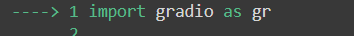
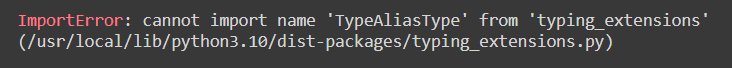

In [ ]:
import gradio as gr

movie_list = new_df['title']

flag = True
# Function to search for movies in the list
def search_movies(query):
    flag = True
    results = [movie for movie in movie_list if query.lower() in movie.lower()]
    # print(results)
    if len(results) < 1 :
        flag = False
        return "Your keywords do not match any title in the datset. Please enter a valid movie name" , flag
    elif len(results) > 1 :
        flag = False
        return ["Please enter keywords to match one particular movie from the list below" , results ], flag
    else:
        return results[0] ,flag


# Function to recommend top 5 related movies based on input
# is already made above

# Function to integrate search and recommend
def search_and_recommend(query):
    # Search for movies
    try:
        search_results , flag = search_movies(query)
        if flag == True:
            # Recommend top 5 related movies using search results as input
            recommend_results = recommend(search_results)
            return {"Search Results": search_results,"Recommendation Results": recommend(search_results)}

        else:
            # give error
            return search_results

    except Exception as e:
        return f"Error: {str(e)}"

# Create a Gradio interface with a text input for search
iface = gr.Interface(
    fn=search_and_recommend,
    inputs=gr.Textbox(),
    outputs=gr.Textbox(),
    live=True,
    title="Movie Search & Recommender",
    description="Enter the name of a movie to search and get recommendations below."
)

# Launch the Gradio interface
iface.launch()

In [ ]:
# !pip install typing_extensions==4.7.1

In [16]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiofiles                         23.2.1
aiohttp                          3.8.6
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.6.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.5.0
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.0
attrs                            23.1.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.13.1
backcall                         0.2.0
be